In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
import keras.applications import 

In [3]:
from keras.applications.mobilenet import MobileNet

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 
# 사전에 훈련된 모델을 가져오기
# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

17235968/17225924 [==============================] - 0s 0us/step
0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 ReLU False
4 DepthwiseConv2D False
5 BatchNormalization False
6 ReLU False
7 Conv2D False
8 BatchNormalization False
9 ReLU False
10 ZeroPadding2D False
11 DepthwiseConv2D False
12 BatchNormalization False
13 ReLU False
14 Conv2D False
15 BatchNormalization False
16 ReLU False
17 DepthwiseConv2D False
18 BatchNormalization False
19 ReLU False
20 Conv2D False
21 BatchNormalization False
22 ReLU False
23 ZeroPadding2D False
24 DepthwiseConv2D False
25 BatchNormalization False
26 ReLU False
27 Conv2D False
28 BatchNormalization False
29 ReLU False
30 DepthwiseConv2D False
31 BatchNormalization False
32 ReLU False
33 Conv2D False
34 BatchNormalization False
35 ReLU False
36 ZeroPadding2D False
37 DepthwiseConv2D False
38 BatchNormalization False
39 ReLU False
40 Conv2D False
41 BatchNormalization False
42 ReLU False
43 DepthwiseConv2D False
44 BatchNormalization F

In [4]:
#훈련시키려는 입력에 대한 레이어를 추가
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [5]:
# 모델에 모든 레이어를 추가하고 모델 요약을 print
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Set our class number to 4
num_classes = 4

FC_Head = lw(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [6]:
# 모델에 제공한 테스트 및 검증 데이터 세트를 확인하고 수정
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/MyDrive/work1/transfer_learning/test_dataset/'
validation_data_dir = '/content/drive/MyDrive/work1/transfer_learning/validation_dataset/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 1600 images belonging to 4 classes.
Found 397 images belonging to 4 classes.


In [7]:
# 모델을 훈련하고 이 모델을 특정 파일 확장자 ".h5"로 저장
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("Facial_recogNet.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 100,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 800
nb_validation_samples = 200

# We only train 5 EPOCHS 
epochs = 500
batch_size = 5

history = model.fit_generator(
    train_generator,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/500
50/50 [==============================] - 773s 15s/step - loss: 3.4502 - accuracy: 0.3345 - val_loss: 1.1335 - val_accuracy: 0.5315

Epoch 00001: val_loss improved from inf to 1.13350, saving model to Facial_recogNet.h5
Epoch 2/500
50/50 [==============================] - 21s 422ms/step - loss: 1.0631 - accuracy: 0.5657 - val_loss: 0.5167 - val_accuracy: 0.7783

Epoch 00002: val_loss improved from 1.13350 to 0.51666, saving model to Facial_recogNet.h5
Epoch 3/500
50/50 [==============================] - 21s 419ms/step - loss: 0.9023 - accuracy: 0.6293 - val_loss: 0.6126 - val_accuracy: 0.7028

Epoch 00003: val_loss did not improve from 0.51666
Epoch 4/500
50/50 [==============================] - 20s 399ms/step - loss: 0.7146 - accuracy: 0.7168 - val_loss: 0.5972 - val_accuracy: 0.7154

Epoch 00004: val_loss did not improve from 0.51666
Epoch 5/500
50/50 [==============================] - 21s 414ms/step - loss: 0.7773 - accuracy: 0.6878 - val_loss: 0.5007 - val_accuracy: 0.79

In [8]:
from keras.models import load_model

classifier = load_model('Facial_recogNet.h5')

Class - jeny


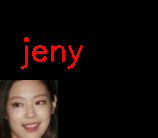

Class - jisu


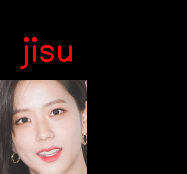

Class - lisa


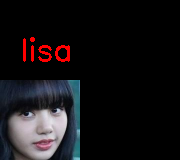

Class - rose


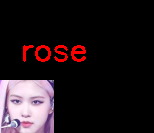

Class - lisa


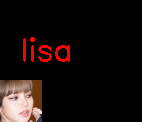

Class - rose


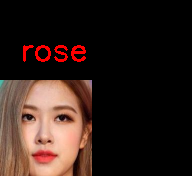

Class - jisu


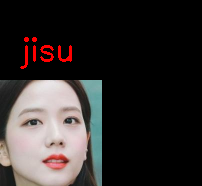

Class - lisa


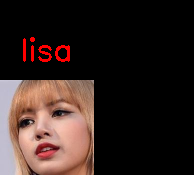

Class - rose


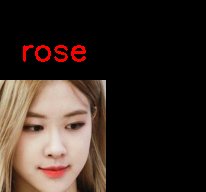

Class - jeny


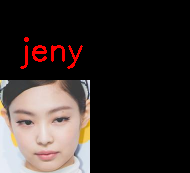

Class - jeny


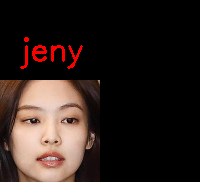

Class - jisu


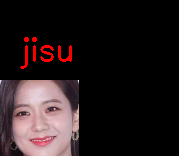

Class - lisa


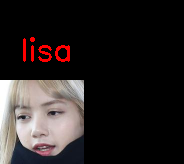

Class - lisa


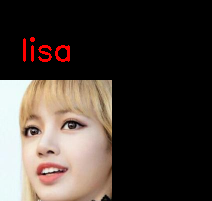

Class - jeny


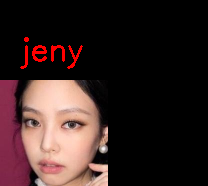

Class - rose


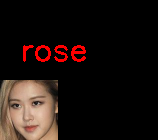

Class - lisa


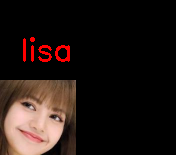

Class - jisu


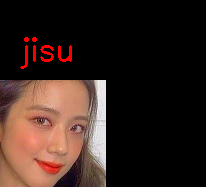

Class - jeny


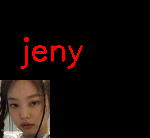

Class - rose


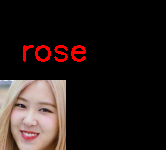

In [13]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from os import listdir
from os.path import isfile, join

facial_recog_dict = {"[0]":"jeny","[1]":"jisu", "[2]":"lisa", "[3]":"rose"}

facial_recog_dict_n = {"jeny":"jeny", "jisu":"jisu","lisa":"lisa", "rose":"rose"}

def draw_test(name, pred, im):
    facial = facial_recog_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, facial, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2_imshow(expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + facial_recog_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,20):
    input_im = getRandomImage("/content/drive/MyDrive/work1/transfer_learning/validation_dataset/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original)
    cv2.waitKey(0)

cv2.destroyAllWindows()